In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import time

## Loading dataset

In [2]:
def get_year_from_title(title):
    years = re.findall(r'(\d{4})', title)
    if len(years) > 0:
        year = int(years[-1])
    else: year = 0
    return year

movies_df = pd.read_csv('./temp/ml-latest-small/movies.csv')
movies_df['genres'] = movies_df['genres'].map(lambda x: x.split('|'))
movies_df['year'] = movies_df['title'].map(get_year_from_title)
movies_df = movies_df.explode('genres')
movies_df = pd.get_dummies(data=movies_df, prefix='', prefix_sep='', columns=['genres'], drop_first=True)
movies_df = movies_df.groupby(by=['movieId', 'title', 'year']).sum()
movies_df = movies_df.sort_index()
movies_df = movies_df.reset_index()
movies_df = movies_df.set_index('movieId')
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
users_df = pd.read_csv('./temp/ml-latest-small/ratings.csv')
users_df = users_df.drop('timestamp', axis=1)

# maybe average rating is a good feature to find out whether a user will like this movie or not
average_rating = users_df.drop('userId', axis=1).groupby('movieId').mean()
# maybe rating counts for this movie is a goood feature to find out whether a user will like this movie or not
rating_count = users_df.drop('userId', axis=1).groupby(['movieId']).count()

users_df = users_df.set_index('movieId')
users_df.head(100)

,userId,rating
movieId,,
1,1,4.0
3,1,4.0
6,1,4.0
47,1,5.0
50,1,5.0
...,...,...
1445,1,3.0
1473,1,4.0
1500,1,4.0


### Create Movie/User rating dataset

In [4]:
movie_rating_df = users_df.join(movies_df, on='movieId')
# save the titles mapping, movieId to title, for evaluation
titles = movie_rating_df['title']
movie_rating_df = movie_rating_df.drop('title', axis=1)

movie_rating_df['avg_rating'] = average_rating
movie_rating_df['cnt_rating'] = rating_count
movie_rating_df = movie_rating_df.drop_duplicates()
movie_rating_df

,userId,rating,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating,cnt_rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.920930,215
3,1,4.0,1995,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.259615,52
6,1,4.0,1995,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,3.946078,102
47,1,5.0,1995,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,3.975369,203
50,1,5.0,1995,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,4.237745,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166534,610,4.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3.333333,6
168248,610,5.0,2017,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.142857,7
168250,610,5.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.633333,15


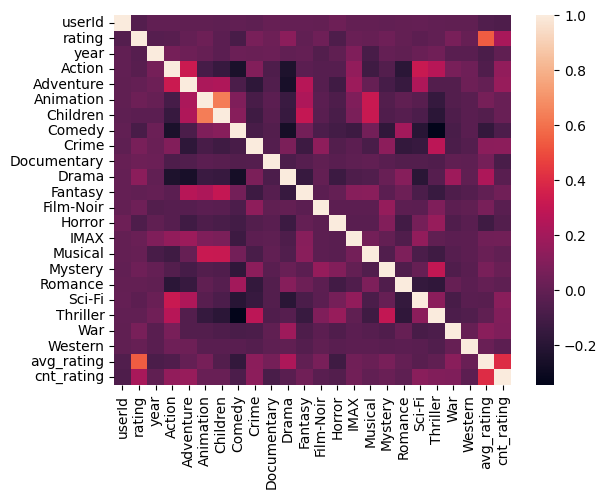

In [5]:
sns.heatmap(movie_rating_df.corr());

### Getting data ready

In [6]:
from sklearn.model_selection import train_test_split

movie_rating_df['intercept'] = 1
movie_features = movie_rating_df.drop(['userId', 'rating'], axis=1).values.astype('float32')
users = movie_rating_df['userId'].values
users = keras.utils.to_categorical(users).astype('float32')
Y = movie_rating_df['rating'].values.astype('float32')

# normalize the data
mu_movie = np.mean(movie_features, axis=0)
sigma_movie = np.std(movie_features, axis=0)
movie_features = (movie_features - mu_movie) / (sigma_movie + 1e-12)


# split the data into training set and validation set
training_movies, test_movies, training_users, test_users, training_ratings, test_ratings = train_test_split(movie_features,
                                                                                                            users, 
                                                                                                            Y,
                                                                                                            test_size=0.2, shuffle=True)
print(f'Training movies has the shape', training_movies.shape)
print(f'Training users has the shape', training_users.shape)
print(f'Training ratings has the shape', training_ratings.shape)
print()
print(f'Test movies has the shape', test_movies.shape)
print(f'Test users has the shape', test_users.shape)
print(f'Test ratings has the shape', test_ratings.shape)

Training movies has the shape (80544, 23)
Training users has the shape (80544, 611)
Training ratings has the shape (80544,)

Test movies has the shape (20137, 23)
Test users has the shape (20137, 611)
Test ratings has the shape (20137,)


### Create the pipeline

In [7]:
BATCH_SIZE = 512
BUFFER = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((training_movies, training_users, training_ratings))
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_movies, test_users, test_ratings))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [8]:
for movie, user, rate in train_ds.take(1):
    print(movie)
    print(np.argmax(user, axis=-1))
    print(rate)

tf.Tensor(
[[ 0.23300885 -0.66121995 -0.56186825 ... -0.89049    -0.868836
   0.        ]
 [-0.67839086 -0.66121995 -0.56186825 ...  0.76885635  0.05092045
   0.        ]
 [ 0.7730976  -0.66121995 -0.56186825 ...  0.23290665 -0.7074752
   0.        ]
 ...
 [-0.30707985  1.512356    1.7797768  ... -0.24547787 -0.7720195
   0.        ]
 [ 0.30051994  1.512356   -0.56186825 ...  0.88329387 -0.7558834
   0.        ]
 [ 0.13174222 -0.66121995 -0.56186825 ... -1.5833744  -0.43316188
   0.        ]], shape=(512, 23), dtype=float32)
[111 380 306  64 390 239 391 464 482 182 140 122 490 292 226 555 448 566
 474 438 606 294 396 326 580 511 480 210  68 171   4 558 339 487 202 222
 199  68 263 414 308 563 414  23 356 103 117 351 432 182 414  57 501 380
  63 560 182 599 218 599 325 222 542  68 469 480 381 562 330 380 474 153
 246 606 226  59 610 555 414 169 554 534 610 525 332  68 380 387 251 563
 604 144 198 115  28 524 480 389 599 305  42 178 410 168  89 103 181   1
 469 318 103 415 368 325 561 39

## Define the model

In [9]:
from keras.layers import Dense, Activation, Dropout, Input, Dot
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError, Metric
from keras.models import Model

Each user has a parameter called $\theta$. For example user 1 might have $\theta^{(1)} = \begin{bmatrix}0\\5\\3\end{bmatrix}$ (Imagine we have only 3 categories) that case a movie with categories $\begin{bmatrix}1\\0\\1\end{bmatrix}$ is expected to get the rating as below:
$$
\begin{equation*}
    \text{rating} = \begin{bmatrix}0\\5\\3\end{bmatrix}^\top \cdot \begin{bmatrix}1\\0\\1\end{bmatrix} = 3
\end{equation*}
$$

In [10]:
class ContentBasedRecommender(Model):
    def __init__(self, units, features, num_users, dropout_rate=0.2):
        super(ContentBasedRecommender, self).__init__()
        self.features = features
        self.num_users = num_users
        self.units = units
        self.dropout_rate = dropout_rate

        self.user_dense1 = Dense(units=units // 4, activation='relu')
        self.user_dense2 = Dense(units=units // 2, activation='relu')
        self.user2vec = Dense(units=units, name='user2vec')

        self.movie_dense1 = Dense(units=units // 4, activation='relu')
        self.movie_dense2 = Dense(units=units // 2, activation='relu')
        self.movie2vec = Dense(units=units, name='movie2vec')
        self.dot = Dot(axes=1, name='dot')

        self.dropout = Dropout(dropout_rate)

        self.build(features, num_users)

    def build(self, features, num_users):
        movie = Input(shape=(features,))
        user = Input(shape=(num_users,))
        self.call(movie, user)
        self.built = True

    def call(self, movie, user, training=False):
        # movie has the shape [B, features] 
        # user has the shape [B, num_users]

        # user2vec mapps each user to feature_dimensional space: [B, features]
        user = self.user_dense1(user)
        user = self.dropout(user, training=training)
        user = self.user_dense2(user)
        user = self.dropout(user, training=training)
        user = self.user2vec(user)

        movie = self.movie_dense1(movie)
        movie = self.dropout(movie, training=training)
        movie = self.movie_dense2(movie)
        movie = self.dropout(movie, training=training)
        movie = self.movie2vec(movie)

        return self.dot([user, movie])

In [11]:
model = ContentBasedRecommender(units=1024, 
                                features=movie_features.shape[-1], 
                                num_users=users.shape[-1], 
                                dropout_rate=0.4)
model.summary()

Model: "content_based_recommender"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               156672    
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 user2vec (Dense)            (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 256)               6144      
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 movie2vec (Dense)           (None, 1024)              525312    
                                                                 
 dot (Dot)                   (None, 1)   

### Define the loss function
It is important to ignore ratings of zero since it does not mean the user has given the movie zero but it means the movie is left unrated

In [12]:
loss_obj = MeanSquaredError()
def loss_func(y_true, y_pred):
    mask = tf.logical_not(tf.equal(y_true, 0))
    loss = loss_obj(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = loss * mask
    return tf.reduce_mean(loss)

In [13]:
class MaskedMAE(Metric):
    def __init__(self, name='mae_masked', **kwargs):
        super(MaskedMAE, self).__init__(name=name, **kwargs)

        self.summation = self.add_weight(name='sum', 
                                         shape=(), 
                                         dtype='float32', 
                                         initializer='zeros')
        self.count = self.add_weight(name='count',
                                     shape=(), 
                                     dtype='float32', 
                                     initializer='zeros')

    def update_state(self, y_true, y_pred):
        y_true = tf.reshape(y_true, shape=(-1,))
        y_pred = tf.reshape(y_pred, shape=(-1,))
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        mask = tf.logical_not(tf.math.equal(y_true, 0))
        mae = tf.math.abs(y_true - y_pred)
        mask = tf.cast(mask, dtype=mae.dtype)
        mae *= mask
        mae = tf.reduce_sum(mae, axis=-1)
        self.summation.assign_add(mae)
        self.count.assign_add(tf.reduce_sum(mask, axis=-1))

    def result(self):
        return self.summation / self.count if self.count != 0.0 else 0.0

    def reset_states(self):
        self.summation.assign(0.0)
        self.count.assign(0.0)

In [14]:
def get_scheduler(initial_learning_rate=1e-3, min_learning_rate=1e-5, weight=0.9):
    def func(epoch):
        return max(initial_learning_rate * weight ** (epoch), min_learning_rate)
    return func

In [15]:
train_mae = MaskedMAE(name='train_mae')
validation_mae = MaskedMAE(name='test_mae')
optimizer = Adam()
scheduler = get_scheduler(initial_learning_rate=3e-3, weight=0.95)

## Train

In [16]:
@tf.function
def training_step(movie, user, y_true):
    loss = 0.0
    with tf.GradientTape() as tape:
        y_pred = model(movie, user, training=True)
        loss = loss_func(y_true, y_pred)
        train_mae.update_state(y_true, y_pred)
        
    variables = model.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss

In [17]:
@tf.function
def validation_step(movie, user, y_true):
    y_pred = model(movie, user, training=False)
    loss = loss_func(y_true, y_pred)
    validation_mae.update_state(y_true, y_pred)
    return loss

In [18]:
EPOCHS = 100
train_mean_losses = []
valid_mean_losses = []
train_maes = []
valid_maes = []

for epoch in range(EPOCHS):
    train_mae.reset_states()
    validation_mae.reset_states()
    mean_train_loss = 0.0
    mean_valid_loss = 0.0
    start = time.time()
    learning_rate = scheduler(epoch)
    optimizer.learning_rate = learning_rate
    print(f'Epoch {epoch + 1:>3}')

    for step, (movie, user, y_true) in enumerate(train_ds):
        loss = training_step(movie, user, y_true)
        
        mae = train_mae.result()
        mean_train_loss = mean_train_loss + (1 / (step + 1)) * (loss - mean_train_loss)
        end = time.time()
        print(f'\r{int(end - start):>3} sec | Step {step:>3}\tLoss: {mean_train_loss:>2.4f}\t MAE: {mae:>2.4f}', end='')
    print()
    train_mean_losses.append(mean_train_loss)
    train_maes.append(mae)

    for step, (movie, user, y_true) in enumerate(test_ds):
        loss = validation_step(movie, user, y_true)

        mae = validation_mae.result()
        mean_valid_loss = mean_valid_loss + (1 / (step + 1)) * (loss - mean_valid_loss)
        end = time.time()
        print(f'\r{int(end - start):>3} sec | Step {step:>3}\tLoss: {mean_valid_loss:>2.4f}\t MAE: {mae:>2.4f}', end='')
    print()
    valid_mean_losses.append(mean_valid_loss)
    valid_maes.append(mae)

history = {'loss':train_mean_losses, 'val_loss':valid_mean_losses, 'mae':train_maes, 'val_mae':valid_maes}

Epoch   1


I0000 00:00:1714685340.745792  158600 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  4 sec | Step 157	Loss: 1.5758	 MAE: 0.91475
  4 sec | Step  39	Loss: 0.9395	 MAE: 0.7987
Epoch   2
  0 sec | Step 157	Loss: 0.7461	 MAE: 0.6681
  0 sec | Step  39	Loss: 0.8329	 MAE: 0.7425
Epoch   3
  0 sec | Step 157	Loss: 0.7133	 MAE: 0.6497
  0 sec | Step  39	Loss: 0.7741	 MAE: 0.7065
Epoch   4
  0 sec | Step 157	Loss: 0.7040	 MAE: 0.6440
  0 sec | Step  39	Loss: 0.7462	 MAE: 0.6892
Epoch   5
  0 sec | Step 157	Loss: 0.6972	 MAE: 0.6408
  0 sec | Step  39	Loss: 0.7483	 MAE: 0.6915
Epoch   6
  0 sec | Step 157	Loss: 0.6892	 MAE: 0.6365
  0 sec | Step  39	Loss: 0.6757	 MAE: 0.6420
Epoch   7
  0 sec | Step 157	Loss: 0.6798	 MAE: 0.6329
  0 sec | Step  39	Loss: 0.7020	 MAE: 0.6623
Epoch   8
  0 sec | Step 157	Loss: 0.6720	 MAE: 0.6278
  0 sec | Step  39	Loss: 0.6955	 MAE: 0.6579
Epoch   9
  0 sec | Step 157	Loss: 0.6697	 MAE: 0.6267
  0 sec | Step  39	Loss: 0.6922	 MAE: 0.6565
Epoch  10
  0 sec | Step 157	Loss: 0.6648	 MAE: 0.6245
  0 sec | Step  39	Loss: 0.6782	 MAE: 0.6471
Epoch  11

## Evaluation

In [19]:
user = keras.utils.to_categorical([249] * movie_features.shape[0], num_classes=users.shape[-1])
pred = model(movie_features, user, training=False)
indx_pred = np.argsort(pred, axis=0)[::-1, 0]

for i in range(10):
    print(titles.iloc[indx_pred[i]])
    print(pred[indx_pred[i]][0].numpy())
    print()

Hugo (2011)
4.819153

Winnie the Pooh Goes Visiting (1971)
4.8107433

Investigation Held by Kolobki (1986)
4.8025584

Total Recall (2012)
4.7963715

Ghost Graduation (2012)
4.7940044

Stitch! The Movie (2003)
4.793268

Flushed Away (2006)
4.7906284

Thing, The (2011)
4.790591

Expendables, The (2010)
4.785397

Man on the Flying Trapeze (1935)
4.7771015



In [20]:
max_loss = 0
y_pred = model(test_movies, test_users, training=False)
for i in range(100):
    y_hat = y_pred[i][0].numpy()
    y_true = test_ratings[i]
    print(f'Predicted {y_hat:>2.2} and the true rating was {y_true}')
    max_loss = max(max_loss, np.abs(y_hat - y_true))

Predicted 2.7 and the true rating was 3.0
Predicted 3.3 and the true rating was 4.0
Predicted 3.1 and the true rating was 2.5
Predicted 3.2 and the true rating was 4.0
Predicted 3.5 and the true rating was 3.0
Predicted 2.3 and the true rating was 2.5
Predicted 3.6 and the true rating was 3.0
Predicted 3.8 and the true rating was 4.0
Predicted 4.1 and the true rating was 5.0
Predicted 3.9 and the true rating was 5.0
Predicted 3.8 and the true rating was 3.5
Predicted 3.6 and the true rating was 3.5
Predicted 3.2 and the true rating was 3.5
Predicted 3.6 and the true rating was 3.0
Predicted 4.2 and the true rating was 4.5
Predicted 2.4 and the true rating was 3.0
Predicted 3.2 and the true rating was 3.5
Predicted 2.6 and the true rating was 3.0
Predicted 3.1 and the true rating was 3.5
Predicted 3.0 and the true rating was 3.0
Predicted 4.0 and the true rating was 4.0
Predicted 3.8 and the true rating was 5.0
Predicted 2.4 and the true rating was 2.5
Predicted 4.0 and the true rating 

In [21]:
max_loss

2.2802997

In [23]:
model.save('./models/content_based_v1.tf')

INFO:tensorflow:Assets written to: ./models/content_based_v1.tf/assets


INFO:tensorflow:Assets written to: ./models/content_based_v1.tf/assets
